In [1]:
import copy
from functools import partial
import gc
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification

2022-04-30 21:29:44.247017: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-30 21:29:44.247046: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# generate some data
s = partial(map_to_constant, c=0.01)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="chisq", threshold=0.5,
                                  noise_distribution="chisq", noise_scale=s)
x, y = eg.generate_labeled(120096)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:100096, :], y[:100096]
x_val, y_val = x[100096:, :], y[100096:]

In [3]:
def opt_name(optimizer):
    return str(optimizer).split("object")[0].split(".")[-1].strip().lower()

optimizer_lookup = {
    opt_name(opt): opt for opt in  
    [keras.optimizers.Nadam(learning_rate=3e-5), 
     keras.optimizers.SGD(learning_rate=5e-3), 
     keras.optimizers.RMSprop(learning_rate=5e-3),
     keras.optimizers.Adam(learning_rate=3e-3),
     keras.optimizers.Adadelta(learning_rate=1e-1),
     keras.optimizers.Adamax(learning_rate=7e-3)]
}

optimal_schedules = [
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=3e-5),
        "learning_rate": 3e-5,
        "batch": 256,
        "epoch": 28
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 256,
        "epoch": 59
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=1e-2),
        "learning_rate" :1e-2,
        "batch": 8,
        "epoch": 1
    },
    {
        "optimizer": keras.optimizers.RMSprop(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 8,
        "epoch": 1# 0.1781
    },
    {
        "optimizer": keras.optimizers.Adam(learning_rate=3e-3),
        "learning_rate": 3e-3,
        "batch": 8,
        "epoch": 1# 0.2076
    },
    {
        "optimizer": keras.optimizers.Adadelta(learning_rate=1e-1),
        "learning_rate": 1e-1,
        "batch": 8,
        "epoch": 2# 0.2354
    },
    {
        "optimizer": keras.optimizers.Adamax(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 1# 0.2249
    },
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 4# 0.1905
    }
]

In [4]:
scan_results = []
champion_params = None
champion_loss = np.inf
for params in optimal_schedules:
    lr = params["learning_rate"]
    for learning_rate in [0.8*lr, lr, 1.2*lr]:
        optimizer = params["optimizer"]
        optimizer.learning_rate.assign(learning_rate)
        num_epochs = int(1.4*params["epoch"] + 2)
        batch_size = int(params["batch"])
        model = keras.Sequential()
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(1, activation="sigmoid"))
        model.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=["accuracy", "AUC"]
        )
        history = model.fit(
            x_train,
            y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
        )
        
        history_dict = history.history
        val_loss = history_dict["val_loss"]
        val_auc = history_dict["val_auc"]
        val_accuracy = history_dict["val_accuracy"]
        epochs = range(1, len(val_loss)+1)
        
        best_loss = {"loss": val_loss[np.argmin(val_loss)], "epoch": epochs[np.argmin(val_loss)]}
        best_auc = {"auc": val_auc[np.argmax(val_auc)], "epoch": epochs[np.argmax(val_auc)]}
        best_accuracy = {"accuracy": val_accuracy[np.argmax(val_accuracy)], "epoch": epochs[np.argmax(val_accuracy)]}
        
        ps = {k: copy.deepcopy(v) for k, v in params.items() if k not in ["optimizer", "model"]}
        ps["optimizer"] = opt_name(optimizer)
        ps["learning_rate"] = copy.deepcopy(learning_rate)
        ps["best_loss"] = best_loss
        ps["best_auc"] = best_auc
        ps["best_accuracy"] = best_accuracy
        print(ps)
        scan_results.append(ps)
        
        if best_loss["loss"] < champion_loss:
            champion_loss = best_loss["loss"]
            champion_params = {k: copy.deepcopy(v) for k, v in ps.items()}
            champion_params["model"] = keras.models.clone_model(model)
        

model = keras.models.clone_model(champion_params["model"])

Epoch 1/41


2022-04-30 21:29:47.405897: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-30 21:29:47.405980: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-30 21:29:47.406007: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-04-30 21:29:47.407517: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


391/391 [==============================] - 3s 4ms/step - loss: 0.6908 - accuracy: 0.5066 - auc: 0.5697 - val_loss: 0.6754 - val_accuracy: 0.5173 - val_auc: 0.6743
Epoch 2/41
391/391 [==============================] - 1s 3ms/step - loss: 0.6804 - accuracy: 0.5161 - auc: 0.6212 - val_loss: 0.6687 - val_accuracy: 0.5278 - val_auc: 0.7437
Epoch 3/41
391/391 [==============================] - 1s 3ms/step - loss: 0.6743 - accuracy: 0.5273 - auc: 0.6492 - val_loss: 0.6632 - val_accuracy: 0.5411 - val_auc: 0.7915
Epoch 4/41
391/391 [==============================] - 1s 3ms/step - loss: 0.6672 - accuracy: 0.5411 - auc: 0.6798 - val_loss: 0.6573 - val_accuracy: 0.5587 - val_auc: 0.8275
Epoch 5/41
391/391 [==============================] - 1s 3ms/step - loss: 0.6611 - accuracy: 0.5576 - auc: 0.7025 - val_loss: 0.6510 - val_accuracy: 0.5870 - val_auc: 0.8525
Epoch 6/41
391/391 [==============================] - 1s 3ms/step - loss: 0.6553 - accuracy: 0.5722 - auc: 0.7184 - val_loss: 0.6441 - val_ac

391/391 [==============================] - 1s 3ms/step - loss: 0.6218 - accuracy: 0.6514 - auc: 0.7903 - val_loss: 0.6005 - val_accuracy: 0.7711 - val_auc: 0.9291
Epoch 6/41
391/391 [==============================] - 1s 3ms/step - loss: 0.6040 - accuracy: 0.6850 - auc: 0.8058 - val_loss: 0.5754 - val_accuracy: 0.8191 - val_auc: 0.9382
Epoch 7/41
391/391 [==============================] - 1s 3ms/step - loss: 0.5831 - accuracy: 0.7133 - auc: 0.8210 - val_loss: 0.5483 - val_accuracy: 0.8569 - val_auc: 0.9451
Epoch 8/41
391/391 [==============================] - 1s 3ms/step - loss: 0.5614 - accuracy: 0.7336 - auc: 0.8317 - val_loss: 0.5163 - val_accuracy: 0.8731 - val_auc: 0.9529
Epoch 9/41
391/391 [==============================] - 1s 3ms/step - loss: 0.5371 - accuracy: 0.7533 - auc: 0.8450 - val_loss: 0.4847 - val_accuracy: 0.8841 - val_auc: 0.9596
Epoch 10/41
391/391 [==============================] - 1s 3ms/step - loss: 0.5127 - accuracy: 0.7668 - auc: 0.8576 - val_loss: 0.4545 - val_a

391/391 [==============================] - 1s 3ms/step - loss: 0.4694 - accuracy: 0.7977 - auc: 0.8893 - val_loss: 0.4084 - val_accuracy: 0.9054 - val_auc: 0.9831
Epoch 10/41
391/391 [==============================] - 1s 3ms/step - loss: 0.4410 - accuracy: 0.8113 - auc: 0.8995 - val_loss: 0.3769 - val_accuracy: 0.9007 - val_auc: 0.9858
Epoch 11/41
391/391 [==============================] - 1s 3ms/step - loss: 0.4161 - accuracy: 0.8217 - auc: 0.9077 - val_loss: 0.3461 - val_accuracy: 0.9044 - val_auc: 0.9878
Epoch 12/41
391/391 [==============================] - 1s 3ms/step - loss: 0.3939 - accuracy: 0.8296 - auc: 0.9150 - val_loss: 0.3246 - val_accuracy: 0.8982 - val_auc: 0.9890
Epoch 13/41
391/391 [==============================] - 1s 3ms/step - loss: 0.3782 - accuracy: 0.8348 - auc: 0.9197 - val_loss: 0.3037 - val_accuracy: 0.9015 - val_auc: 0.9901
Epoch 14/41
391/391 [==============================] - 1s 3ms/step - loss: 0.3618 - accuracy: 0.8423 - auc: 0.9253 - val_loss: 0.2880 - v

391/391 [==============================] - 1s 3ms/step - loss: 0.5584 - accuracy: 0.7441 - auc: 0.8278 - val_loss: 0.5315 - val_accuracy: 0.8563 - val_auc: 0.9468
Epoch 14/84
391/391 [==============================] - 1s 3ms/step - loss: 0.5470 - accuracy: 0.7488 - auc: 0.8346 - val_loss: 0.5150 - val_accuracy: 0.8657 - val_auc: 0.9536
Epoch 15/84
391/391 [==============================] - 1s 3ms/step - loss: 0.5333 - accuracy: 0.7587 - auc: 0.8454 - val_loss: 0.4991 - val_accuracy: 0.8702 - val_auc: 0.9593
Epoch 16/84
391/391 [==============================] - 1s 3ms/step - loss: 0.5208 - accuracy: 0.7674 - auc: 0.8525 - val_loss: 0.4819 - val_accuracy: 0.8766 - val_auc: 0.9639
Epoch 17/84
391/391 [==============================] - 1s 3ms/step - loss: 0.5070 - accuracy: 0.7741 - auc: 0.8608 - val_loss: 0.4648 - val_accuracy: 0.8813 - val_auc: 0.9680
Epoch 18/84
391/391 [==============================] - 1s 3ms/step - loss: 0.4952 - accuracy: 0.7780 - auc: 0.8661 - val_loss: 0.4501 - v

Epoch 60/84
391/391 [==============================] - 1s 3ms/step - loss: 0.2901 - accuracy: 0.8732 - auc: 0.9506 - val_loss: 0.2310 - val_accuracy: 0.8924 - val_auc: 0.9951
Epoch 61/84
391/391 [==============================] - 1s 3ms/step - loss: 0.2875 - accuracy: 0.8743 - auc: 0.9513 - val_loss: 0.2246 - val_accuracy: 0.8982 - val_auc: 0.9951
Epoch 62/84
391/391 [==============================] - 1s 3ms/step - loss: 0.2873 - accuracy: 0.8748 - auc: 0.9515 - val_loss: 0.2287 - val_accuracy: 0.8938 - val_auc: 0.9952
Epoch 63/84
391/391 [==============================] - 1s 3ms/step - loss: 0.2850 - accuracy: 0.8763 - auc: 0.9522 - val_loss: 0.2318 - val_accuracy: 0.8898 - val_auc: 0.9953
Epoch 64/84
391/391 [==============================] - 1s 3ms/step - loss: 0.2813 - accuracy: 0.8777 - auc: 0.9536 - val_loss: 0.2339 - val_accuracy: 0.8870 - val_auc: 0.9954
Epoch 65/84
391/391 [==============================] - 1s 3ms/step - loss: 0.2823 - accuracy: 0.8762 - auc: 0.9531 - val_loss

391/391 [==============================] - 1s 3ms/step - loss: 0.4025 - accuracy: 0.8210 - auc: 0.9073 - val_loss: 0.3194 - val_accuracy: 0.9061 - val_auc: 0.9881
Epoch 22/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3921 - accuracy: 0.8249 - auc: 0.9119 - val_loss: 0.3052 - val_accuracy: 0.9104 - val_auc: 0.9894
Epoch 23/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3814 - accuracy: 0.8298 - auc: 0.9161 - val_loss: 0.2912 - val_accuracy: 0.9158 - val_auc: 0.9905
Epoch 24/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3742 - accuracy: 0.8340 - auc: 0.9190 - val_loss: 0.2805 - val_accuracy: 0.9167 - val_auc: 0.9912
Epoch 25/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3648 - accuracy: 0.8376 - auc: 0.9228 - val_loss: 0.2715 - val_accuracy: 0.9163 - val_auc: 0.9919
Epoch 26/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3600 - accuracy: 0.8390 - auc: 0.9244 - val_loss: 0.2670 - v

Epoch 68/84
391/391 [==============================] - 1s 3ms/step - loss: 0.2618 - accuracy: 0.8865 - auc: 0.9593 - val_loss: 0.2139 - val_accuracy: 0.8952 - val_auc: 0.9962
Epoch 69/84
391/391 [==============================] - 1s 3ms/step - loss: 0.2612 - accuracy: 0.8869 - auc: 0.9593 - val_loss: 0.2136 - val_accuracy: 0.8953 - val_auc: 0.9962
Epoch 70/84
391/391 [==============================] - 1s 3ms/step - loss: 0.2601 - accuracy: 0.8875 - auc: 0.9598 - val_loss: 0.2144 - val_accuracy: 0.8946 - val_auc: 0.9962
Epoch 71/84
391/391 [==============================] - 1s 3ms/step - loss: 0.2626 - accuracy: 0.8858 - auc: 0.9589 - val_loss: 0.2204 - val_accuracy: 0.8910 - val_auc: 0.9963
Epoch 72/84
391/391 [==============================] - 1s 3ms/step - loss: 0.2579 - accuracy: 0.8876 - auc: 0.9603 - val_loss: 0.2132 - val_accuracy: 0.8956 - val_auc: 0.9963
Epoch 73/84
391/391 [==============================] - 1s 3ms/step - loss: 0.2593 - accuracy: 0.8870 - auc: 0.9599 - val_loss

391/391 [==============================] - 1s 2ms/step - loss: 0.3117 - accuracy: 0.8628 - auc: 0.9429 - val_loss: 0.2288 - val_accuracy: 0.9103 - val_auc: 0.9940
Epoch 30/84
391/391 [==============================] - 1s 2ms/step - loss: 0.3107 - accuracy: 0.8620 - auc: 0.9430 - val_loss: 0.2259 - val_accuracy: 0.9097 - val_auc: 0.9941
Epoch 31/84
391/391 [==============================] - 1s 2ms/step - loss: 0.3103 - accuracy: 0.8632 - auc: 0.9431 - val_loss: 0.2253 - val_accuracy: 0.9092 - val_auc: 0.9943
Epoch 32/84
391/391 [==============================] - 1s 2ms/step - loss: 0.3020 - accuracy: 0.8663 - auc: 0.9461 - val_loss: 0.2235 - val_accuracy: 0.9082 - val_auc: 0.9944
Epoch 33/84
391/391 [==============================] - 1s 2ms/step - loss: 0.3014 - accuracy: 0.8663 - auc: 0.9463 - val_loss: 0.2222 - val_accuracy: 0.9077 - val_auc: 0.9946
Epoch 34/84
391/391 [==============================] - 1s 2ms/step - loss: 0.3001 - accuracy: 0.8666 - auc: 0.9468 - val_loss: 0.2195 - v

Epoch 76/84
391/391 [==============================] - 1s 2ms/step - loss: 0.2367 - accuracy: 0.8982 - auc: 0.9660 - val_loss: 0.2325 - val_accuracy: 0.8776 - val_auc: 0.9971
Epoch 77/84
391/391 [==============================] - 1s 2ms/step - loss: 0.2358 - accuracy: 0.8987 - auc: 0.9664 - val_loss: 0.2230 - val_accuracy: 0.8840 - val_auc: 0.9971
Epoch 78/84
391/391 [==============================] - 1s 2ms/step - loss: 0.2344 - accuracy: 0.8986 - auc: 0.9665 - val_loss: 0.2350 - val_accuracy: 0.8752 - val_auc: 0.9972
Epoch 79/84
391/391 [==============================] - 1s 2ms/step - loss: 0.2370 - accuracy: 0.8985 - auc: 0.9659 - val_loss: 0.2338 - val_accuracy: 0.8763 - val_auc: 0.9972
Epoch 80/84
391/391 [==============================] - 1s 2ms/step - loss: 0.2329 - accuracy: 0.8999 - auc: 0.9671 - val_loss: 0.2334 - val_accuracy: 0.8767 - val_auc: 0.9973
Epoch 81/84
391/391 [==============================] - 1s 2ms/step - loss: 0.2345 - accuracy: 0.8989 - auc: 0.9666 - val_loss

Epoch 2/3
12512/12512 [==============================] - 24s 2ms/step - loss: 0.2744 - accuracy: 0.8796 - auc: 0.9537 - val_loss: 0.2348 - val_accuracy: 0.8816 - val_auc: 0.9850
Epoch 3/3
12512/12512 [==============================] - 25s 2ms/step - loss: 0.2592 - accuracy: 0.8875 - auc: 0.9587 - val_loss: 0.2814 - val_accuracy: 0.8421 - val_auc: 0.9862
{'learning_rate': 0.0036, 'batch': 8, 'epoch': 1, 'optimizer': 'adam', 'best_loss': {'loss': 0.18712501227855682, 'epoch': 1}, 'best_auc': {'auc': 0.9862394332885742, 'epoch': 3}, 'best_accuracy': {'accuracy': 0.9247499704360962, 'epoch': 1}}
Epoch 1/4
12512/12512 [==============================] - 25s 2ms/step - loss: 0.5669 - accuracy: 0.6933 - auc: 0.7998 - val_loss: 0.3621 - val_accuracy: 0.8857 - val_auc: 0.9687
Epoch 2/4
12512/12512 [==============================] - 23s 2ms/step - loss: 0.3767 - accuracy: 0.8273 - auc: 0.9127 - val_loss: 0.2599 - val_accuracy: 0.8900 - val_auc: 0.9889
Epoch 3/4
12512/12512 [======================

Epoch 6/7
12512/12512 [==============================] - 25s 2ms/step - loss: 0.3067 - accuracy: 0.8706 - auc: 0.9443 - val_loss: 0.2562 - val_accuracy: 0.9227 - val_auc: 0.9834
Epoch 7/7
12512/12512 [==============================] - 25s 2ms/step - loss: 0.3061 - accuracy: 0.8691 - auc: 0.9442 - val_loss: 0.2065 - val_accuracy: 0.9216 - val_auc: 0.9822
{'learning_rate': 0.007, 'batch': 8, 'epoch': 4, 'optimizer': 'nadam', 'best_loss': {'loss': 0.20648767054080963, 'epoch': 7}, 'best_auc': {'auc': 0.9840642213821411, 'epoch': 2}, 'best_accuracy': {'accuracy': 0.9226999878883362, 'epoch': 6}}
Epoch 1/7
12512/12512 [==============================] - 26s 2ms/step - loss: 0.3532 - accuracy: 0.8412 - auc: 0.9248 - val_loss: 0.2923 - val_accuracy: 0.8640 - val_auc: 0.9781
Epoch 2/7
12512/12512 [==============================] - 25s 2ms/step - loss: 0.3239 - accuracy: 0.8597 - auc: 0.9371 - val_loss: 0.2772 - val_accuracy: 0.8723 - val_auc: 0.9768
Epoch 3/7
12512/12512 [======================

In [16]:
optimizer = optimizer_lookup[champion_params["optimizer"]]
learning_rate = champion_params["learning_rate"]
optimizer.learning_rate.assign(learning_rate)
batch_size = champion_params["batch"]
num_epochs = champion_params["best_loss"]["epoch"]

# train a Keras MLP
model = keras.Sequential()
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", "AUC"]
)
history = model.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/2
12512/12512 [==============================] - 29s 2ms/step - loss: 0.3469 - accuracy: 0.8478 - auc: 0.9269 - val_loss: 0.1783 - val_accuracy: 0.9294 - val_auc: 0.9848
Epoch 2/2
12512/12512 [==============================] - 26s 2ms/step - loss: 0.3219 - accuracy: 0.8682 - auc: 0.9357 - val_loss: 0.1781 - val_accuracy: 0.9316 - val_auc: 0.9852


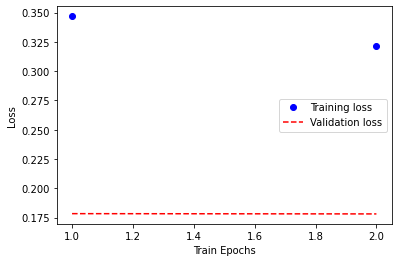

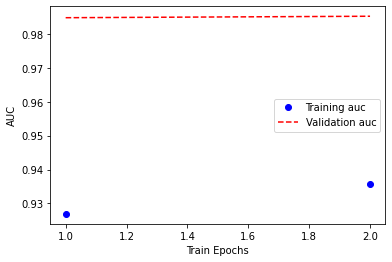

In [17]:
# inspect metrics
history_dict = history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
auc = history_dict["auc"]
val_auc = history_dict["val_auc"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r--", label="Validation loss")
plt.xlabel("Train Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, auc, "bo", label="Training auc")
plt.plot(epochs, val_auc, "r--", label="Validation auc")
plt.xlabel("Train Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [18]:
n = 5
s = 100

p = model.predict(x_val[:1000,:])[:, 0]

scores = eg.get_scores(x_val[:1000,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:1000,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

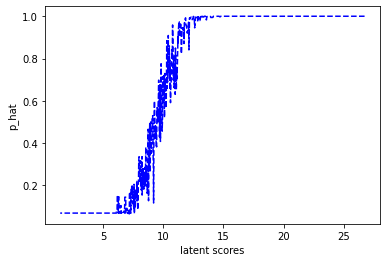

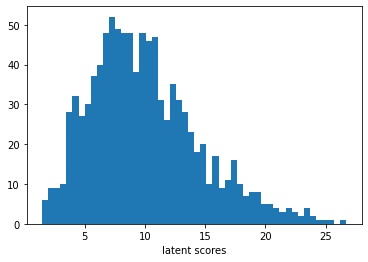

In [19]:
plt.plot(scores, p, '--b')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

plt.hist(scores, bins=50)
plt.xlabel('latent scores')
plt.show()

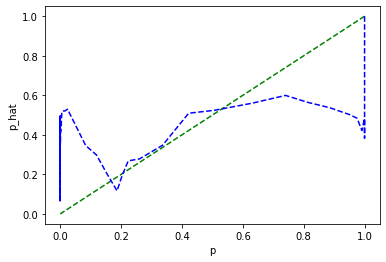

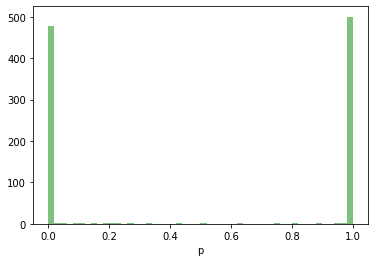

In [22]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

plt.hist(probs, bins=50, color='g', alpha=0.5)
plt.xlabel('p')
plt.show()

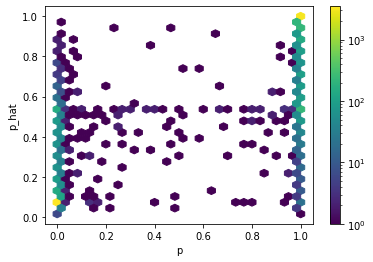

In [29]:
n = 1
s = 100

p = model.predict(x_val[:10000,:])[:, 0]

scores = eg.get_scores(x_val[:10000,:])

probs = eg.get_probabilities(x_val[:10000,:])[1]

plt.hexbin(probs, p, gridsize=30, bins='log')
plt.colorbar()
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

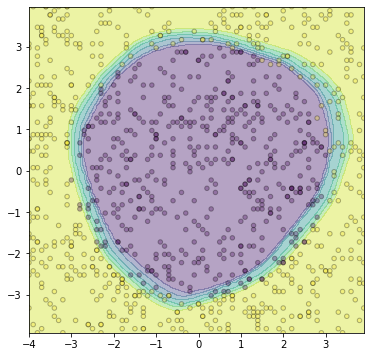

In [10]:
# Plot decision regions
I, J = 2, 6
x_min, x_max = x_val[:, I].min(), x_val[:, I].max()
y_min, y_max = x_val[:, J].min(), x_val[:, J].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
xxyy = np.c_[xx.ravel(), yy.ravel()]
x_ = np.zeros((xxyy.shape[0], 10))
x_[:, I] = xxyy[:, 0]
x_[:, J] = xxyy[:, 1]
z = model.predict(x_)
z = z.reshape(xx.shape)
y_ = eg.get_labels(x_)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.contourf(xx, yy, z, alpha=0.4)
ixs = np.random.randint(0, y_.shape[0]-1, 1000)
ax.scatter(x_[ixs, I], x_[ixs, J], c=y_[ixs], s=20, alpha=0.3, edgecolor="k")
plt.show()

#model.summary()

In [11]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 60)                660       
                                                                 
 dropout_72 (Dropout)        (None, 60)                0         
                                                                 
 dense_97 (Dense)            (None, 60)                3660      
                                                                 
 dropout_73 (Dropout)        (None, 60)                0         
                                                                 
 dense_98 (Dense)            (None, 60)                3660      
                                                                 
 dropout_74 (Dropout)        (None, 60)                0         
                                                                 
 dense_99 (Dense)            (None, 1)               

In [12]:
champion_params

{'learning_rate': 0.005,
 'batch': 8,
 'epoch': 1,
 'optimizer': 'rmsprop',
 'best_loss': {'loss': 0.15694880485534668, 'epoch': 2},
 'best_auc': {'auc': 0.9877735376358032, 'epoch': 2},
 'best_accuracy': {'accuracy': 0.9402999877929688, 'epoch': 2},
 'model': <keras.engine.sequential.Sequential at 0x7fb83a5874f0>}

In [13]:
scan_results

[{'learning_rate': 2.4e-05,
  'batch': 256,
  'epoch': 28,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.2622841000556946, 'epoch': 40},
  'best_auc': {'auc': 0.9928587675094604, 'epoch': 41},
  'best_accuracy': {'accuracy': 0.8964499831199646, 'epoch': 25}},
 {'learning_rate': 3e-05,
  'batch': 256,
  'epoch': 28,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.243728369474411, 'epoch': 30},
  'best_auc': {'auc': 0.9938891530036926, 'epoch': 41},
  'best_accuracy': {'accuracy': 0.9053500294685364, 'epoch': 17}},
 {'learning_rate': 3.6e-05,
  'batch': 256,
  'epoch': 28,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.25132670998573303, 'epoch': 25},
  'best_auc': {'auc': 0.9942300319671631, 'epoch': 41},
  'best_accuracy': {'accuracy': 0.9095500111579895, 'epoch': 8}},
 {'learning_rate': 0.004,
  'batch': 256,
  'epoch': 59,
  'optimizer': 'sgd',
  'best_loss': {'loss': 0.22460395097732544, 'epoch': 61},
  'best_auc': {'auc': 0.9962645769119263, 'epoch': 84},
  'best_accuracy'

### Tuning notes: 

Data: train 100096 / val 20000

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 80/80 **val_loss: 0.4221** - val_accuracy: 0.7657 - val_auc: 0.9857

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 60/80 **val_loss: 0.3241** - val_accuracy: 0.8463 - val_auc: 0.9856

--
* model: 40, 0.25, 40, 0.25, 40, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 40/80 **val_loss: 0.2726** - val_accuracy: 0.8848 - val_auc: 0.9889

--
* model: 50, 0.25, 50, 0.25, 50, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 38/80 **val_loss: 0.2555** - val_accuracy: 0.8832 - val_auc: 0.9916

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 28/80 **val_loss: 0.2552** - val_accuracy: 0.8909 - val_auc: 0.9929

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 48/80 **0.2557** - val_accuracy: 0.8771 - val_auc: 0.9935

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 20, 0.25, 6, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 47/80 **0.3482** - val_accuracy: 0.8346 - val_auc: 0.9910

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 5e-3
* Epoch: 59/80 **0.2176** - val_accuracy: 0.8953 - val_auc: 0.9961

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 3e-3
* Epoch: 80/100 **0.2205** - val_accuracy: 0.8970 - val_auc: 0.9951

--
8/1e-2=> 0.2021 - val_accuracy: 0.9207 - val_auc: 0.9904
8/8e-3=> 0.26...
8/1.3e-2=> 0.25